# Major project. Gender and Age classification.

# 45761655 Chia-Hao Hsu

# Introduction

---



This notebook is for the major project submission for COMP7220/8220, on the [image/language] dataset and task.  It contains the following sections:

*   a description of the selected conventional ML model;
*   some notes about the choices made in building the conventional ML model;
*   a description of the selected deep learning model;
*   some notes about the choices made in building the deep model; and
*   a discussion of the performance of the two models.


# Loading Data

---



Install packages that we need for the project.

Set the random seed with np and TensorFlow for the conventional Machine learning model and Deep learning model.

In [1]:
import numpy as np
import cv2
import os
from os.path import join
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, GlobalMaxPool2D
from tensorflow.keras import Sequential
from tensorflow.keras import losses
from keras.layers import Conv2D, Lambda, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
import pandas as pd
from keras.utils.np_utils import to_categorical
from keras.layers.normalization import BatchNormalization
drive.mount('/content/drive/')

np.random.seed(77)
tf.random.set_seed(77)

Mounted at /content/drive/


Create the path of the document that I have stored.

In [2]:
dataset_directory = '/content/drive/My Drive/ML/facial-gender-recognition/' 

Read the image dataset and extract one sample from the training dataset.




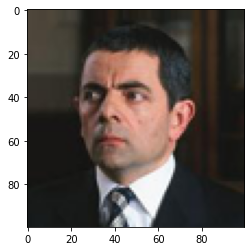

In [3]:
images_train = np.load(join(dataset_directory, 'train_images.npy'))
plt.imshow(images_train[0], cmap=plt.cm.binary)

Read the labeled dataset related to the image dataset and extract one sample from the training dataset. 
From the result, we can clearly know the '1-48' means that 1=male and 48=age.

In [4]:
labels_train = np.load(join(dataset_directory, 'train_labels.npy'))
labels_train[0]

'1-48'

To split the age and gender label, 
I extract the first character and the last two characters as two np arrays, such as label_train_age and lavel_age_gender.

Additionally, I read the private image dataset for the private Kaggle competition.

In [5]:
#Gender part
def transform_labels_gender(labels_vec):
  return np.array([int(x[0]) for x in labels_vec])

def transform_labels_g(labels_vec):
  return transform_labels_gender(labels_vec)

#Age part
def transform_labels_age(labels_vec):
  return np.array([int(x[2:]) for x in labels_vec])

def transform_labels_a(labels_vec):
  return transform_labels_age(labels_vec)

#Read the training image and labeled datset
images_train = np.load(join(dataset_directory, 'train_images.npy'))
labels_train = np.load(join(dataset_directory, 'train_labels.npy'))
labels_train_gender = transform_labels_g(labels_train)
labels_train_age = transform_labels_a(labels_train)

#Read the validation image and labeled datset

images_val = np.load(join(dataset_directory, 'val_images.npy'))
labels_val = np.load(join(dataset_directory, 'val_labels.npy'))
labels_val_gender = transform_labels_g(labels_val)
labels_val_age = transform_labels_a(labels_val)

#Read the testing image and labeled datset
images_test_public = np.load(join(dataset_directory, 'test_images.npy'))

#Read the private testing image and labeled datset
private_images_test_public = np.load(join(dataset_directory, 'test_priv_images.npy'))

Show the one sample of the original dataset 
with age and gender label.

Text(0.5, 1.0, '48')

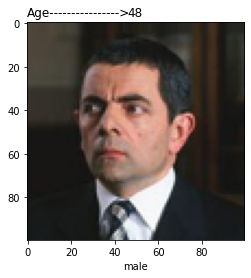

In [6]:
gender = ['female', 'male']
plt.imshow(images_train[0], cmap=plt.cm.binary)
plt.xlabel(gender[labels_train_gender[0]])
plt.title("Age---------------->", loc = 'left')
plt.title(labels_train_age[0])

To adjust the size of the image dataset, using reshape function to fix them.
Moreover, show detailed information about the size and sample for these datasets.

In [7]:
image_size = 100
images_train = images_train.reshape([-1, image_size, image_size, 3]) / 255.0
images_val = images_val.reshape([-1, image_size, image_size, 3]) / 255.0
images_test_public = images_test_public.reshape([-1, image_size, image_size, 3]) / 255.0
private_images_test_public = private_images_test_public.reshape([-1, image_size, image_size, 3]) / 255.0

print('-----The shape of age and gender labels in training, validation, testing, private testing dataset-----')

print(images_train.shape)
print(images_val.shape)
print(images_test_public.shape)
print(private_images_test_public.shape)

print('\n')

print('-----The first 10 sample of age and gender labels-----')


print(labels_train_gender[:10])
print(labels_train_age[:10])
print(labels_val_gender[:10])
print(labels_val_age[:10])

-----The shape of age and gender labels in training, validation, testing, private testing dataset-----
(11580, 100, 100, 3)
(1332, 100, 100, 3)
(1039, 100, 100, 3)
(1233, 100, 100, 3)


-----The first 10 sample of age and gender labels-----
[1 1 1 1 1 1 1 1 1 1]
[48 48 48 48 48 48 48 48 48 48]
[1 1 1 1 1 1 1 1 1 0]
[88 70 78 85 92 76 70 92 73 27]


#Exploratory Data Analysis

---



From the above resize processing, we can see that the size of the image becomes 100x100 from the original sample.

Figure 1

Text(0.5, 1.0, '48')

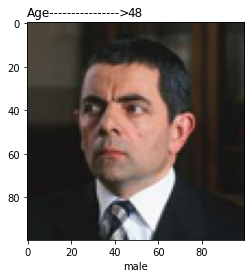

In [8]:
plt.imshow(images_train[0], cmap=plt.cm.binary)
plt.xlabel(gender[labels_train_gender[0]])
plt.title("Age---------------->", loc = 'left')
plt.title(labels_train_age[0])

Here is the distribution of gender in training and validation labels.

From the two pie charts, we can see that the proportion of males and females is not significantly different, and the number of males is slightly higher than that of females.

Figure 2

Text(0, 0.5, '')

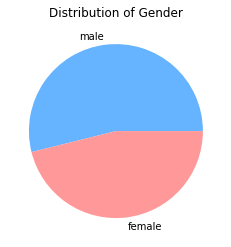

In [9]:
df_gender_train=pd.DataFrame(labels_train_gender, columns = ['Gender'])
colors = ['#66b3ff','#ff9999','#99ff99','#ffcc99']
ax= df_gender_train.value_counts().plot(kind='pie',labels=["male","female"],colors=colors)
ax.set_title("Distribution of Gender")
plt.ylabel("")

Figure 3

Text(0, 0.5, '')

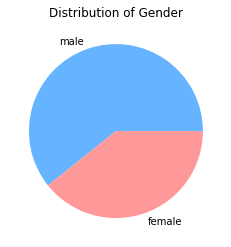

In [10]:
df_gender_val=pd.DataFrame(labels_val_gender, columns = ['Gender'])
ax=df_gender_val.value_counts().plot(kind='pie',labels=["male","female"],colors=colors)
ax.set_title("Distribution of Gender")
plt.ylabel("")

# Conventional ML Model

---



The final model that produced the best-performing predictions for the Kaggle submission (accuracy 77.17%) was a random forest model with the hyperparameter n_estimators=1000.



Check the dimension of the image dataset. It includes the 11580 pictures, 100 of height, 100 of width, and three Red, Green, Blue (RGB) channels with the color model.

In [11]:
images_train.shape

(11580, 100, 100, 3)

To run the conventional Machine learning model, we must transfer the number of dimensions data from 4 to 2, so I use the reshape function to combine the number column into 30,000 (*100x100x3*).

In [12]:
images_train_ml=np.reshape(images_train, (images_train.shape[0], -1))
images_train_ml.shape

(11580, 30000)

In [13]:
images_val_ml=np.reshape(images_val, (images_val.shape[0], -1))
images_val_ml.shape

(1332, 30000)

Select the Random Forest classification model to train the training image and label dataset and then predicting the validation image value with the model. 

In [14]:
rf_clf = RandomForestClassifier(n_estimators=1000)
rf_clf.fit(images_train_ml, labels_train_gender)
pre_rf=rf_clf.predict(images_val_ml)

Show the classification report of the model.

In [15]:
print(classification_report(labels_val_gender, pre_rf))

              precision    recall  f1-score   support

           0       0.76      0.61      0.68       523
           1       0.78      0.88      0.82       809

    accuracy                           0.77      1332
   macro avg       0.77      0.74      0.75      1332
weighted avg       0.77      0.77      0.77      1332



Print the confusion matrix to know the 
true positive, true negative, false positive, and false negative value.

In [16]:
print(confusion_matrix(labels_val_gender, pre_rf))

[[317 206]
 [ 98 711]]


From the classification report, we can 
get the score of accuracy from the model.

In [17]:
# Your code goes here.
print(accuracy_score(labels_val_gender, pre_rf))

0.7717717717717718


Read the submission of the gender classification CSV file as a dataframe.

In [18]:
test = pd.read_csv('/content/drive/My Drive/ML/facial-gender-recognition/predictions_gender_label1.csv')
test

,ID,Prediction
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
1034,1034,1
1035,1035,1
1036,1036,1
1037,1037,1


Predict the classification of the public test image dataset with the random forest model.

In [19]:
images_test_public_ml=np.reshape(images_test_public, (images_test_public.shape[0], -1))

predict_data =rf_clf.predict(images_test_public_ml)

Make sure the size of the predicted data format fitted to submission dataset.

In [20]:
predict_data.shape

(1039,)

Combine the data from submission ID and predict data into a new submission data.

In [21]:
submission = pd.DataFrame({ "ID": test["ID"],
                            "Prediction": predict_data })
submission.to_csv("/content/drive/My Drive/ML/facial-gender-recognition/45761655-conv(10).csv", index=False)

# Notes on the Conventional Machine Learning Model

---



1. Before applying the machine learning model, I would like to the Exploratory Data Analysis. We need to know the predictor and response variable, so in Figure 1, I show the first sample of the picture, and then in Figure 2 and Figure 3, I plot the distribution of gender in the training and validation dataset with pie charts.

2. To achieve the Conventional Machine Learning Model for the project, the first thing to deal with is doing data pre-processing. I have used the data normalization, divided the image into 255 because the scale from RGB is from 0 to 255. After the step, we can get the range of values from 0 to 1 in each pixel.


3. To make sure the image dataset can input to the Random Forest model, we need to reduce the number of dimensions from four to two as a dataframe/table format that we often see in the tutorial, so I integrated the height, width, and channel as the column in the dataframe. That is why the shape of the image training dataset is (11580, 30000) because the 30000 is from 100x100x3.


4. Adjusting the hyperparameter in the Random Forest, the n_estimators=1000 gives the best accuracy with 77.1%, which is a perfect start for Gender Recognition, but the drawback of machine learning is that consuming too much time to execute the model. It takes almost 30 minutes to finish the task. For me, it may not be a producible strategy.
 

# Deep Learning Model (Gender)


---


The final model that produced the best-performing predictions for the Kaggle submission (accuracy 87%) includes Convolutional Neural Network layers BatchNormalization layers, MaxPooling2D layers, Dropout layers, GlobalMaxPool2D layer, and Dense layers. In the Kaggle competition, I got a 9th place through using the complex model to achieve the goal of Gender Recognition.

Create the CNN model of the gender classification.



In [22]:
model = tf.keras.Sequential([
  layers.Conv2D(16,kernel_size=(3,3), activation="relu" ,input_shape=(100,100,3), padding='same'),
  layers.Conv2D(32, kernel_size=(3,3), activation="relu",padding='same'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.3),

  layers.Conv2D(64, kernel_size=(3,3), activation="relu",padding='same'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.Dropout(0.35),

  layers.Conv2D(128, kernel_size=(3,3), activation="relu",padding='same'),
  layers.MaxPooling2D(pool_size=(2,2)),
  layers.BatchNormalization(),
  layers.Dropout(0.45),

  layers.GlobalMaxPool2D(),
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")])

model.compile(optimizer="adam", 
              loss=losses.BinaryCrossentropy(), 
              metrics=tf.keras.metrics.BinaryAccuracy(name="binary_accuracy", threshold=0.5))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 64)        2

Final check for the shape of the dataset can input to the model.

In [23]:
[e.shape for e in (images_train,images_val,labels_train_gender,labels_val_gender)]

[(11580, 100, 100, 3), (1332, 100, 100, 3), (11580,), (1332,)]

Execute the 20 epochs and saving the history records as "history_gender."
We can get a high binary_accuracy of 0.8377 from the training dataset and val_binary_accuracy of 0.8529 from the validation dataset.

In [24]:
epochs = 20
history_gender = model.fit(images_train, labels_train_gender, validation_data=(images_val, labels_val_gender), epochs=epochs)

Epoch 1/20
362/362 [==============================] - 40s 23ms/step - loss: 0.6974 - binary_accuracy: 0.5976 - val_loss: 0.6674 - val_binary_accuracy: 0.6074
Epoch 2/20
362/362 [==============================] - 8s 21ms/step - loss: 0.6241 - binary_accuracy: 0.6541 - val_loss: 0.6009 - val_binary_accuracy: 0.7147
Epoch 3/20
362/362 [==============================] - 8s 21ms/step - loss: 0.5959 - binary_accuracy: 0.6787 - val_loss: 0.6142 - val_binary_accuracy: 0.7057
Epoch 4/20
362/362 [==============================] - 8s 21ms/step - loss: 0.5754 - binary_accuracy: 0.7004 - val_loss: 0.5898 - val_binary_accuracy: 0.6689
Epoch 5/20
362/362 [==============================] - 8s 21ms/step - loss: 0.5681 - binary_accuracy: 0.7066 - val_loss: 0.5535 - val_binary_accuracy: 0.7252
Epoch 6/20
362/362 [==============================] - 8s 21ms/step - loss: 0.5343 - binary_accuracy: 0.7285 - val_loss: 0.6017 - val_binary_accuracy: 0.6389
Epoch 7/20
362/362 [==============================] - 8s 

Evaluate the model with a validation dataset.

In [25]:
model.evaluate(images_val, labels_val_gender)

42/42 [==============================] - 0s 8ms/step - loss: 0.3743 - binary_accuracy: 0.8529


[0.37429079413414, 0.8528528809547424]

Creating the classification report, we can see that the accuracy is 0.85.

In [26]:
pre_gender_cnn=np.round(model.predict(images_val),0)
pre_gender_cnn=pre_gender_cnn.flatten()
pre_gender_cnn=pre_gender_cnn.astype(int)

print(classification_report(labels_val_gender, pre_gender_cnn))

              precision    recall  f1-score   support

           0       0.80      0.83      0.82       523
           1       0.89      0.87      0.88       809

    accuracy                           0.85      1332
   macro avg       0.84      0.85      0.85      1332
weighted avg       0.85      0.85      0.85      1332



Print the confusion matrix to observe the true positive, true negative, false positive, and false negative values.

In [27]:
print(confusion_matrix(labels_val_gender, pre_gender_cnn))

[[434  89]
 [107 702]]


Create the two graphs about the accuracy and loss trend in the training and validation dataset.

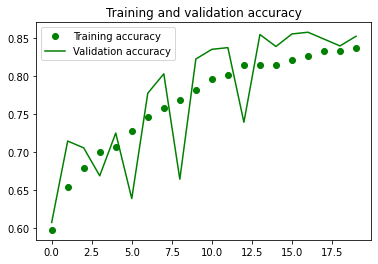

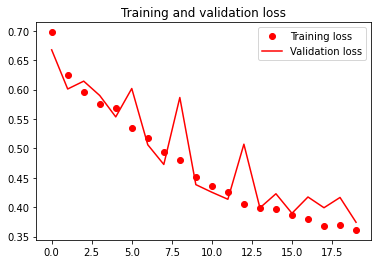

In [28]:
accuracy = history_gender.history['binary_accuracy']
val_accuracy = history_gender.history['val_binary_accuracy']
loss = history_gender.history['loss']
val_loss = history_gender.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Extract the nine samples of the correct classification of gender.



Found 1136 correct labels


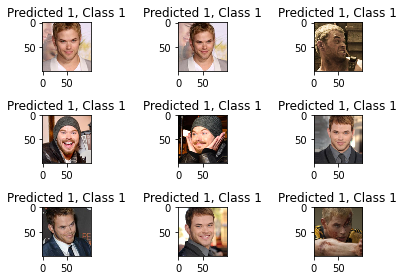

In [29]:
correct_gender = np.where(labels_val_gender==pre_gender_cnn)[0]
print ("Found %d correct labels" % len(correct_gender))
for i, correct_gender in enumerate(correct_gender[1000:1009]):
    plt.subplot(3,3,i+1)
    plt.imshow(images_val[correct_gender], cmap=plt.cm.binary, interpolation='none')
    plt.title("Predicted {}, Class {}".format(pre_gender_cnn[correct_gender], labels_val_gender[correct_gender]))
    plt.tight_layout()

Ensure the public test and private dataset are the one dimension data for us to combine the ID column.

In [30]:
predict_data =model.predict(images_test_public)
predict_data=predict_data.flatten()
print(predict_data.shape)

predict_privated_data =model.predict(private_images_test_public)
predict_privated_data=predict_privated_data.flatten()
print(predict_privated_data.shape)

(1039,)
(1233,)


In [31]:
submission = pd.DataFrame({ "ID": test["ID"],
                            "Prediction": predict_data })

submission

,ID,Prediction
0,0,0.346650
1,1,0.138069
2,2,0.390172
3,3,0.397342
4,4,0.286328
...,...,...
1034,1034,0.058232
1035,1035,0.088101
1036,1036,0.575255
1037,1037,0.320321


Create private test submission data.

In [32]:
test_private = pd.read_csv('/content/drive/My Drive/ML/facial-gender-recognition/prediction_priv_gender.csv')
submission_privated = pd.DataFrame({ "ID": test_private["ID"],
                            "Prediction": predict_privated_data })

submission_privated

,ID,Prediction
0,0,0.875022
1,1,0.747384
2,2,0.694474
3,3,0.791224
4,4,0.926660
...,...,...
1228,1228,0.452848
1229,1229,0.560178
1230,1230,0.460292
1231,1231,0.678890


If the probability higher than 0.5, turning the value into 1.
On the other hand, the rest of the values turn into 0.

In [33]:
submission['Prediction'] = submission['Prediction'].mask(submission['Prediction'] > 0.5, 1)
submission['Prediction'] = submission['Prediction'].mask(submission['Prediction'] <= 0.5, 0)
submission

,ID,Prediction
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0
...,...,...
1034,1034,0.0
1035,1035,0.0
1036,1036,1.0
1037,1037,0.0


If the probability higher than 0.5, turning the value into 1.
On the other hand, the rest of the values turn into 0.

In [34]:
submission_privated['Prediction'] = submission_privated['Prediction'].mask(submission_privated['Prediction'] > 0.5, 1)
submission_privated['Prediction'] = submission_privated['Prediction'].mask(submission_privated['Prediction'] <= 0.5, 0)
submission_privated

,ID,Prediction
0,0,1.0
1,1,1.0
2,2,1.0
3,3,1.0
4,4,1.0
...,...,...
1228,1228,0.0
1229,1229,1.0
1230,1230,0.0
1231,1231,1.0


Change the data type from float to int.

In [35]:
submission['Prediction'] = submission['Prediction'].astype(int)
submission

,ID,Prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
1034,1034,0
1035,1035,0
1036,1036,1
1037,1037,0


Change the data type from float to int.

In [36]:
submission_privated['Prediction'] = submission_privated['Prediction'].astype(int)
submission_privated

,ID,Prediction
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
1228,1228,0
1229,1229,1
1230,1230,0
1231,1231,1


Create the CSV file for the public test and private test data submissions.

In [37]:
submission.to_csv("/content/drive/My Drive/ML/facial-gender-recognition/45761655-deep(3).csv", index=False)

In [38]:
submission_privated.to_csv("/content/drive/My Drive/ML/facial-gender-recognition/45761655-private_deep_gender(2).csv", index=False)

# Notes on the Deep Learning Model (Gender)

---



For the final model, I provide a quick overview of each layer with hyperparameters that I have chosen for the model.



Here is the architecture of the CNN model.


```
model.summary()
```


*  Input layer:
 
 Convolutional layer.
 
 With 16 filters and the size is 3x3. 

 The ReLU activation function and the original size of the image are 100x100x3.

 Use the same padding process to get the same height and width as the input data.



*  Convolutional layer:
 
 With 32 filters and the size is 3x3. 

 The ReLU activation function and the original size of the image are 100x100x3.

 Use the same padding process to get the same height and width as the input data.
*  BatchNormalization layer

*  MaxPooling2D layer: pool size 2x2
*  Dropout layer: rate=0.3

*  Convolutional layer:
 
 With 64 filters and the size is 3x3. 

 The ReLU activation function and the original size of the image are 100x100x3.

 Use the same padding process to get the same height and width as the input data.


*  BatchNormalization layer

*  MaxPooling2D layer: pool size 2x2
*  Dropout layer: rate=0.35


*  Convolutional layer:
 
 With 128 filters and the size is 3x3. 

 The ReLU activation function and the original size of the image are 100x100x3.

 Use the same padding process to get the same height and width as the input data.

*  MaxPooling2D layer: pool size 2x2

*  BatchNormalization layer

*  Dropout layer: rate=0.45

*  GlobalMaxPool2D layer
*  Dense layer: the size of 64, and the ReLU activation function.
*  Dense layer: the size of 1, and the Sigmoid activation function.








Compile the complex model with optimizer="adam," BinaryCrossentropy of the loss function, and threshold with 0.5 to classify the image dataset.

From the two graphs to record the information about accuracy and loss in training and validation dataset, we can know that in the training part, both of accuracy is stable to develop in 20 epochs, but in the validation part, it is fluctuating in 20 epochs, and sometimes it may have sharp increase or decrease. Overall, it does not happen the overfitting issue in the CNN model.

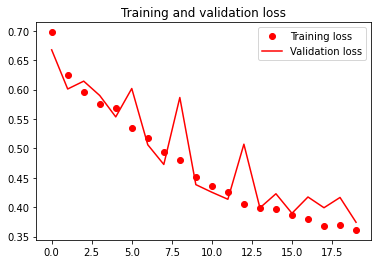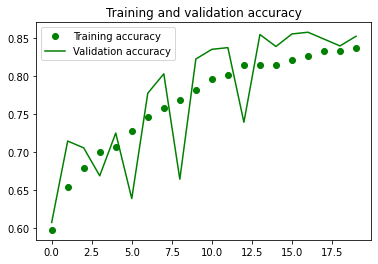

Finally, we get 87% accuracy from the Kaggle competition, and the result is 9th place.

# Discussion of Model Performance and Implementation

Compared to the conventional ML and deep learning models, deep learning accuracy increases by 10%, which is better than conventional ML on the test dataset. I also receive 83% accuracy in the Kaggle competition on the private test data, which is in 10th place.

1. Discussion about what performance on validation set versus public test set might say about your models or the dataset:

 I got 87% accuracy in the test data, but invalidation data, I only have 84%, which means that the training model has an underestimated issue. In my opinion, I believe that it is better than the overfitting issue, and it just shows that my model is related conservative. 

2. Discussion about what performance on private test set versus public test set might say about your models or the dataset:
 
 In two performance results, the accuracy of the test is 87%, but the accuracy of the private test is only 83%. It seems a little different from the two datasets, but from the accuracy of validation is 85%, both the test and private test accuracy are reasonable. The model is still reproducible for people to use in different datasets and get effective results.

3.  Discussion about what inspecting the data might say about your models or the dataset: 
 From the Exploratory Data Analysis part, it is essential to check the distribution of the response variable; if the distribution is unbalanced, it may affect the model to predict correctly. Additionally, if the response variable has an unbalanced issue, we can use Mente-Carol or Boootstraping method to resample the dataset and improve performance. In Figure 2 and Figure 3, there is no unbalance data issue in the project, so we do not need to fix the problem.


4.  Reflection on the resource required for models or other implementation issues:

 To fix the low accuracy in the deep learning model, the solution that I tried to provide is that adjust more hyperparameters and add more hidden layers. Also, the process is doing by learning, using the dropout function to remove the unnecessary neurons in the hidden layer, adding the batch normalization layer to regulate the neuron networks and increase the stability of neuron networks.

5. Deciding to utilize a conventional machine learning model or deep learning can base on accuracy and time-consuming. If the conventional machine learning model costs too much time to execute and the accuracy is not better than the deep learning model, we should choose the deep learning model for the prediction.



# Age classification

---
The final model that produced the best-performing predictions for the Kaggle submission (accuracy 50%) includes Convolutional Neural Network layers BatchNormalization layers, MaxPooling2D layers, Dropout layers, Flatten layer, and Dense layers. In the Kaggle competition, I got a sixth-place by using the complex model to achieve Age Recognition.


Check that any value of age is out of range (6-20, 25-30, 42-48, and 60-98). 

In [39]:
np.unique(labels_val_age)

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 26,
       27, 28, 29, 30, 42, 43, 44, 45, 46, 47, 48, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 78, 80, 81, 84, 85, 88, 92])

In [40]:
np.unique(labels_train_age)

array([ 6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 25, 26,
       27, 28, 29, 30, 42, 43, 44, 45, 46, 47, 48, 60, 61, 62, 63, 64, 65,
       66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82,
       83, 84, 85, 86, 87, 88, 90, 92, 93, 94, 97, 98])

Change each age into the range of age from validation and test labels.

0: 6-20,

1: 25-30,

2: 42-48,

3: 60-98

In [41]:
for i in range(len(labels_train_age)):
  if ((labels_train_age[i]>=6) & (labels_train_age[i]<=20)):
    labels_train_age[i]= 0
  
  if ((labels_train_age[i]>=25) & (labels_train_age[i]<=30)):
    labels_train_age[i]= 1
  
  if ((labels_train_age[i]>=42) & (labels_train_age[i]<=48)):
    labels_train_age[i]= 2
  
  if ((labels_train_age[i]>=60) & (labels_train_age[i]<=98)):
    labels_train_age[i]= 3

In [42]:
for i in range(len(labels_val_age)):
  if ((labels_val_age[i]>=6) & (labels_val_age[i]<=20)):
    labels_val_age[i]= 0
  
  if ((labels_val_age[i]>=25) & (labels_val_age[i]<=30)):
    labels_val_age[i]= 1
  
  if ((labels_val_age[i]>=42) & (labels_val_age[i]<=48)):
    labels_val_age[i]= 2
  
  if ((labels_val_age[i]>=60) & (labels_val_age[i]<=98)):
    labels_val_age[i]= 3

Use np. unique to check the age value transfer into age range format.

In [43]:
np.unique(labels_train_age)

array([0, 1, 2, 3])

In [44]:
np.unique(labels_val_age)

array([0, 1, 2, 3])

#Exploratory Data Analysis

---

Here is the distribution of Age range in training and validation labels.

From the two pie charts, we can see that the proportion of Age range is not significantly different, and the number of from 25 to 30 is the highest.



Text(0, 0.5, '')

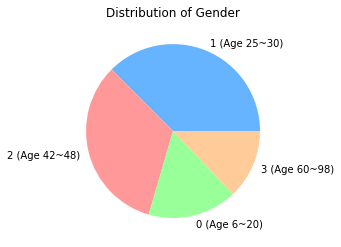

In [45]:
df_age_train=pd.DataFrame(labels_train_age, columns = ['Age'])
ax= df_age_train.value_counts().plot(kind='pie',labels=["1 (Age 25~30)", "2 (Age 42~48)", "0 (Age 6~20)", "3 (Age 60~98)"], colors=colors)
ax.set_title("Distribution of Gender")
plt.ylabel("")

Text(0, 0.5, '')

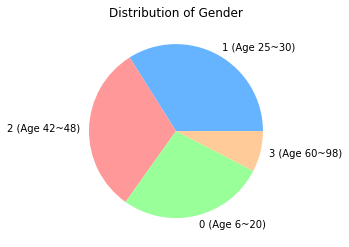

In [46]:
df_age_val=pd.DataFrame(labels_val_age, columns = ['Age'])
ax= df_age_val.value_counts().plot(kind='pie', labels=["1 (Age 25~30)", "2 (Age 42~48)", "0 (Age 6~20)", "3 (Age 60~98)"], colors=colors)
ax.set_title("Distribution of Gender")
plt.ylabel("")

For inputting the label of the age range to the model, we need to do something like one-hot encoding to recognize different categories for the deep learning model.

In [47]:
cat_labels_train_age = to_categorical(labels_train_age)

cat_labels_train_age

array([[0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [48]:
cat_labels_val_age = to_categorical(labels_val_age)

cat_labels_val_age

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

# Deep learning Model (Age)

---



Create the CNN model of the age classification.

In [49]:
model_age = tf.keras.Sequential([
  layers.Conv2D(16,kernel_size=(2,3), activation="relu" ,input_shape=(100,100,3), padding='valid'),
  layers.Conv2D(32, kernel_size=(2,3), activation="relu",padding='same'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Dropout(0.45),

  layers.Conv2D(64, kernel_size=(2,3), activation="relu",padding='same'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.Dropout(0.35),

  layers.Conv2D(128, kernel_size=(2,3), activation="relu",padding='same'),
  layers.MaxPooling2D(pool_size=(3,3)),
  layers.BatchNormalization(),
  layers.Dropout(0.25),
  layers.Flatten(),
  layers.Dense(64, activation="relu"),
  layers.Dense(4, activation="sigmoid")])

model_age.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model_age.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 99, 98, 16)        304       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 99, 98, 32)        3104      
_________________________________________________________________
batch_normalization_3 (Batch (None, 99, 98, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 33, 32, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 33, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 33, 32, 64)        12352     
_________________________________________________________________
batch_normalization_4 (Batch (None, 33, 32, 64)       

Execute the 20 epochs and saving the history records as "history_age."
We cannot get high accuracy of 0.4535 from the training dataset and val_accuracy of 0.5892 from the validation dataset.

In [50]:
epochs = 20
history_age = model_age.fit(images_train, cat_labels_train_age, validation_data=(images_val, cat_labels_val_age), epochs=epochs)


Epoch 1/20
362/362 [==============================] - 8s 19ms/step - loss: 1.4243 - accuracy: 0.3598 - val_loss: 1.3961 - val_accuracy: 0.3183
Epoch 2/20
362/362 [==============================] - 6s 17ms/step - loss: 1.2637 - accuracy: 0.4036 - val_loss: 1.3167 - val_accuracy: 0.3453
Epoch 3/20
362/362 [==============================] - 6s 18ms/step - loss: 1.2417 - accuracy: 0.4244 - val_loss: 1.2612 - val_accuracy: 0.4137
Epoch 4/20
362/362 [==============================] - 6s 17ms/step - loss: 1.2235 - accuracy: 0.4350 - val_loss: 1.3169 - val_accuracy: 0.3716
Epoch 5/20
362/362 [==============================] - 6s 17ms/step - loss: 1.2134 - accuracy: 0.4456 - val_loss: 1.2570 - val_accuracy: 0.4107
Epoch 6/20
362/362 [==============================] - 6s 17ms/step - loss: 1.2002 - accuracy: 0.4453 - val_loss: 1.2278 - val_accuracy: 0.4039
Epoch 7/20
362/362 [==============================] - 6s 17ms/step - loss: 1.1781 - accuracy: 0.4592 - val_loss: 1.3524 - val_accuracy: 0.3979

Evaluate the model with a validation dataset.

In [51]:
model_age.evaluate(images_val, cat_labels_val_age)

42/42 [==============================] - 0s 8ms/step - loss: 1.1852 - accuracy: 0.4535


[1.1851681470870972, 0.4534534513950348]

Creating the classification report, we can see that the micro average in the accuracy is 0.39.

In [52]:
pre_age_cn=np.round(model_age.predict(images_val),0)
print(classification_report(cat_labels_val_age.argmax(axis=1), pre_age_cn.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.37      0.77      0.50       363
           1       0.35      0.30      0.33       452
           2       0.57      0.24      0.34       416
           3       0.31      0.05      0.09       101

    accuracy                           0.39      1332
   macro avg       0.40      0.34      0.31      1332
weighted avg       0.42      0.39      0.36      1332



Print the confusion matrix to observe the result of the classification situation in multiple labels.

In [53]:
print(confusion_matrix(cat_labels_val_age.argmax(axis=1), pre_age_cn.argmax(axis=1)))

[[279  71  12   1]
 [294 137  17   4]
 [159 152  99   6]
 [ 21  29  46   5]]


Create the two graphs about the accuracy and loss trend in the training and validation dataset.

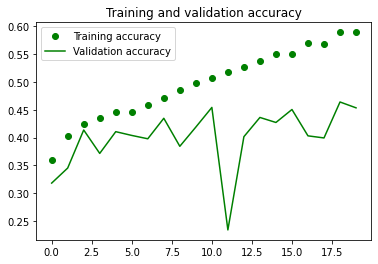

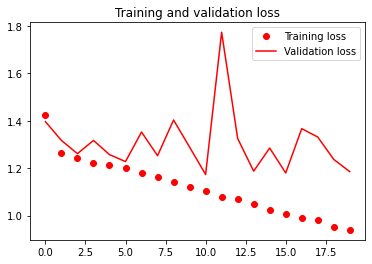

In [54]:
accuracy = history_age.history['accuracy']
val_accuracy = history_age.history['val_accuracy']
loss = history_age.history['loss']
val_loss = history_age.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'go', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'g', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Extract the nine samples of the correct classification of age range.


Found 520 correct labels


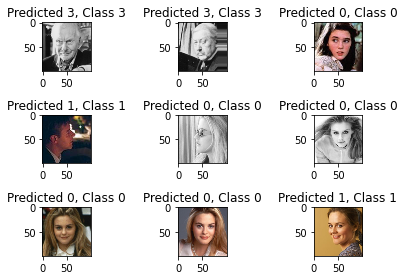

In [55]:
correct = np.where(cat_labels_val_age.argmax(axis=1)==pre_age_cn.argmax(axis=1))[0]
print ("Found %d correct labels" % len(correct))
for i, correct in enumerate(correct[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(images_val[correct], cmap=plt.cm.binary, interpolation='none')
    plt.title("Predicted {}, Class {}".format(pre_age_cn.argmax(axis=1)[correct], cat_labels_val_age.argmax(axis=1)[correct]))
    plt.tight_layout()

Predict the labels from the test dataset and make sure the predefined dimension can fit with the submission format.

In [56]:
pred = model_age.predict_classes(images_test_public)
pred.shape

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


(1039,)

Check that the value of the pred label is in the age range.

In [57]:
pred

array([1, 1, 0, ..., 1, 1, 1])

Create test submission data.


In [58]:
submission_age = pd.DataFrame({ "ID": test["ID"],
                            "Prediction": pred })

submission_age

,ID,Prediction
0,0,1
1,1,1
2,2,0
3,3,2
4,4,1
...,...,...
1034,1034,1
1035,1035,1
1036,1036,1
1037,1037,1


Check the data type in int format.

In [59]:
submission_age.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1039 entries, 0 to 1038
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   ID          1039 non-null   int64
 1   Prediction  1039 non-null   int64
dtypes: int64(2)
memory usage: 16.4 KB


Create the CSV file for test data submissions.

In [60]:
submission_age.to_csv("/content/drive/My Drive/ML/facial-gender-recognition/45761655-age_deep(6).csv", index=False)

# Notes on the Deep Learning Model (Age)

---
For the final model, I provide a quick overview of each layer with hyperparameters that I have chosen for the model.

Here is the architecture of CNN model.


```
model_age.summary()
```


*  Input layer:
 
 Convolutional layer.
 
 With 16 filters and the size is 2x3. 

 The ReLU activation function and the original size of the image are 100x100x3.

 Using the valid in padding process is that without padding.
*  Convolutional layer:
 
 With 32 filters and the size is 2x3. 

 The ReLU activation function and the original size of the image are 100x100x3.

 Use the same padding process to get the same height and width as the input data.


*  BatchNormalization layer

*  MaxPooling2D layer: pool size 3x3
*  Dropout layer: rate=0.45

*  Convolutional layer:
 
 With 64 filters and the size is 2x3. 

 The ReLU activation function and the original size of the image are 100x100x3.

 Use the same padding process to get the same height and width as the input data.


*  BatchNormalization layer

*  MaxPooling2D layer: pool size 3x3
*  Dropout layer: rate=0.35



*  Convolutional layer:
 
 With 128 filters and the size is 2x3. 

 The ReLU activation function and the original size of the image are 100x100x3.

 Use the same padding process to get the same height and width as the input data.
*  BatchNormalization layer

*  MaxPooling2D layer: pool size 3x3
*  Dropout layer: rate=0.25

*  Flatten layer
*  Dense layer: the size of 64, and the ReLU activation function.
*  Dense layer: the size of 4, and the Sigmoid activation function.








Compile the complex model with optimizer="adam", categorical_crossentropy of loss function.

From the two graphs to record the information about accuracy and loss in training and validation dataset, we can know that in the training part, both of accuracy is stable to develop in 20 epochs, but in the validation part, it is fluctuating in 20 epochs, and sometimes it may have sharp increase or decrease. Overall, it happens the overfitting issue in the CNN model.

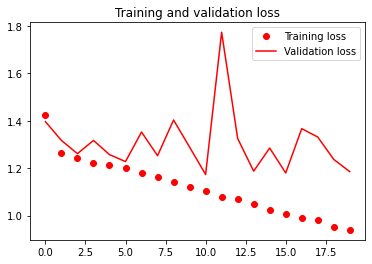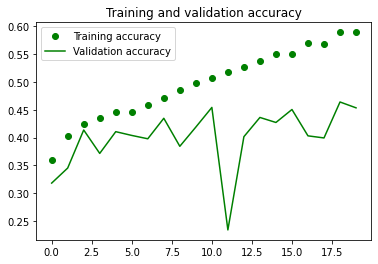

Finally, we get 50% accuracy from the Kaggle competition, and the result is in sixth place.

# Discussion of Model Performance and Implementation

---



Assess the deep learning models and the deep learning accuracy with receiving 50% accuracy in the Kaggle competition, which is in the sixth place.

1. Discussion about what performance on validation set versus public test set might say about your models or the dataset:

 I got 45% accuracy in the test data, but I got 50% invalidation data, which means that the training model has an underestimated issue. In my opinion, I believe that it is better than the overfitting issue, and it just shows that my model is related conservative.

2. Discussion about what inspecting the data might say about your models or the dataset: 
 The accuracy cannot increase to a high level because the number of training data is not enough to classify the validation and test data. There are two ways to solve the problem. It is first adding more data into the training dataset because it can help the model recognize the critical features of each person's face. Data argumentation also is a suitable method, such as flipping images with the horizontal and vertical transfer, rotating the image in 90 degrees to get four pictures from an image, and using conditional GANs to get different styles of the original picture. 


3.  Reflection on the resource required for models or other implementation issues:

 To fix the low accuracy in the deep learning model, the solution that I tried to provide is that adjust more hyperparameters and add more hidden layers. Also, the process is doing by learning, using the dropout function to remove the unnecessary neurons in the hidden layer, adding the batch normalization layer to regulate the neuron networks and increase the stability of neuron networks.
